<p style="text-align:center"> 
    <a href="https://www.linkedin.com/in/flavio-aguirre-12784a252/" target="_blank"> 
    <img src="../assets/logo.png" width="200" alt="Flavio Aguirre Logo"> 
    </a>
</p>

<h1 align="center"><font size="7"><strong>📉 ByeBye Predictor</strong></font></h1>
<br>
<hr>

## Exploratory Data Analysis of Real Reddit User Comments

### Overall objective of this EDA:
Explore, understand, and perform minimal cleaning of Reddit comments to prepare them for the normalization stage, where we will prepare them to serve as input to a supervised churn model.

We must remember that ``the primary objective of this dataset is to provide comments extracted from Reddit as textual input that will be integrated into the first "telco-customer" dataset, a structured dataset containing churn tags``. This integration will allow us to train a churn prediction model that incorporates both structured signals and linguistic patterns present in the comments.

This means that the analysis will be limited to the distribution of the "body" tag and any tags directly related to it or to our target churn tag located in the first dataset, and not to the relationship between those categories in this second dataset.

In [27]:
# We imported library 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS

from collections import Counter

# warning ignore
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [15]:
# Visual style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

<hr>

### Loading and Initial Review of the Dataset

``Objective:`` Check if the data is correctly structured and identify the available columns.


In [16]:
df_comments = pd.read_csv("../data/raw/comments_movistar.csv")
print("\nDataset loaded successfully.\n")

# Display the shape of the dataset
print(f"Dataset shape: {df_comments.shape}. \n")

# Display the data types of each column
print("Name of each column and what type of data it is:")
print(df_comments.dtypes)


Dataset loaded successfully.

Dataset shape: (44, 7). 

Name of each column and what type of data it is:
comment_id       object
body             object
author           object
created_utc     float64
score             int64
parent_id        object
is_submitter       bool
dtype: object


Let's understand each column of data in our dataframe:

| **Column** | **Type** | **What does it represent on Reddit?** |
| -------------- | --------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `comment_id` | `object` | The unique ID of the comment. Reddit usually calls this an `id`. |
| `body` | `object` | The **text of the comment** (content written by the user). |
| `author` | `object` | The username that wrote the comment. |
| `created_utc` | `float64` | The date and time in **UTC timestamp** (Epoch time). Represents the exact moment the comment was posted. |
| `score` | `int64` | Number of **upvotes minus downvotes**. This is an indicator of the comment's popularity or social validation. |
| `parent_id` | `object` | The ID of the post or comment this comment is in reply to. If it starts with `t3_`, it's a post (submission); if it's `t1_`, it's another comment. |
| `is_submitter` | `bool` | `True` if the comment author is also the author of the original post. |

Let's also look at some statistical information:

In [17]:
df_comments.info()
df_comments.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   comment_id    44 non-null     object 
 1   body          44 non-null     object 
 2   author        42 non-null     object 
 3   created_utc   44 non-null     float64
 4   score         44 non-null     int64  
 5   parent_id     44 non-null     object 
 6   is_submitter  44 non-null     bool   
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 2.2+ KB


,comment_id,body,author,created_utc,score,parent_id,is_submitter
count,44,44,42,4.400000e+01,44.000000,44,44
unique,44,44,23,NaN,NaN,24,2
top,m8yc3ia,"No es que son 5000, son 5000 por cada persona ...",Tererebrio,NaN,NaN,t3_1i924b2,False
freq,1,1,16,NaN,NaN,19,28
mean,NaN,NaN,NaN,1.737895e+09,7.340909,NaN,NaN
std,NaN,NaN,NaN,5.856472e+05,18.744231,NaN,NaN
min,NaN,NaN,NaN,1.737743e+09,-17.000000,NaN,NaN
25%,NaN,NaN,NaN,1.737751e+09,1.000000,NaN,NaN
50%,NaN,NaN,NaN,1.737772e+09,2.000000,NaN,NaN
75%,NaN,NaN,NaN,1.737817e+09,6.000000,NaN,NaN


We can see that for many columns missing values ​​are returned, this is because either we have object type data (which can clearly be the case), or there are many missing or corrupt values ​​and therefore their descriptive statistics cannot be calculated directly.

We continue exploring...

****Columns and data types****

In [18]:
# We corroborate by separating each column with its data type
categorical_columns = df_comments.select_dtypes(include=['object']).columns
numerical_columns = df_comments.select_dtypes(include=[np.number]).columns

print("\nData types within the daset:\n")

print("Categorical columns:")
print(categorical_columns.tolist())
print("Total number of categorical columns:", len(categorical_columns))

print("\nNumerical columns:")
print(numerical_columns.tolist())
print("Total number of numerical columns:", len(numerical_columns))

# Detect numerically encoded binary
numeric_binary = [col for col in numerical_columns if df_comments[col].nunique() == 2]
continuous_numeric = [col for col in numerical_columns if col not in numeric_binary]

print("\nNumerically encoded binary columns:")
print(numeric_binary)
print("Total number of numerically encoded binary columns:", len(numeric_binary))
print("\nContinuous numeric columns:")
print(continuous_numeric)
print("Total number of numerically continuous columns:", len(continuous_numeric))


Data types within the daset:

Categorical columns:
['comment_id', 'body', 'author', 'parent_id']
Total number of categorical columns: 4

Numerical columns:
['created_utc', 'score']
Total number of numerical columns: 2

Numerically encoded binary columns:
[]
Total number of numerically encoded binary columns: 0

Continuous numeric columns:
['created_utc', 'score']
Total number of numerically continuous columns: 2


### Missing Values

In [19]:
print("\nMissing values in each column:")
print(df_comments.isnull().sum().sort_values(ascending=False))


Missing values in each column:
author          2
comment_id      0
body            0
created_utc     0
score           0
parent_id       0
is_submitter    0
dtype: int64


Only 2 missing values ​​in the ``'author'`` column.

***Distribution of numerical variables***

Regarding numeric variables, for now, we will analyze only the ``'score'`` category, since we will deal with ``'created_utc'`` in the next step.

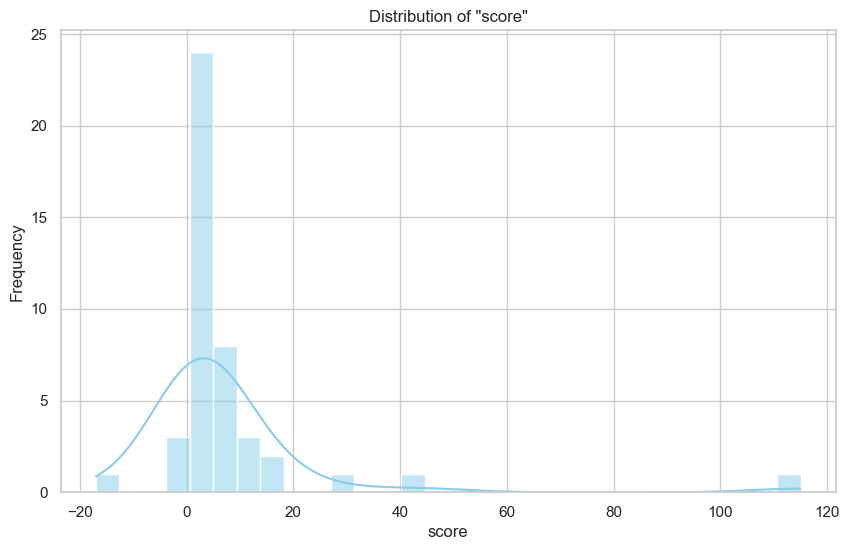

In [20]:
sns.histplot(df_comments['score'].dropna(), kde=True, bins=30, color='skyblue')
plt.title('Distribution of "score"')
plt.xlabel('score')
plt.ylabel('Frequency')
plt.savefig('../reports/figures/eda/reddit-comments/distribution_score.png')
plt.show()

***Outliers***
For this, we use a ``boxplot`` to visually observe the outliers for this label.

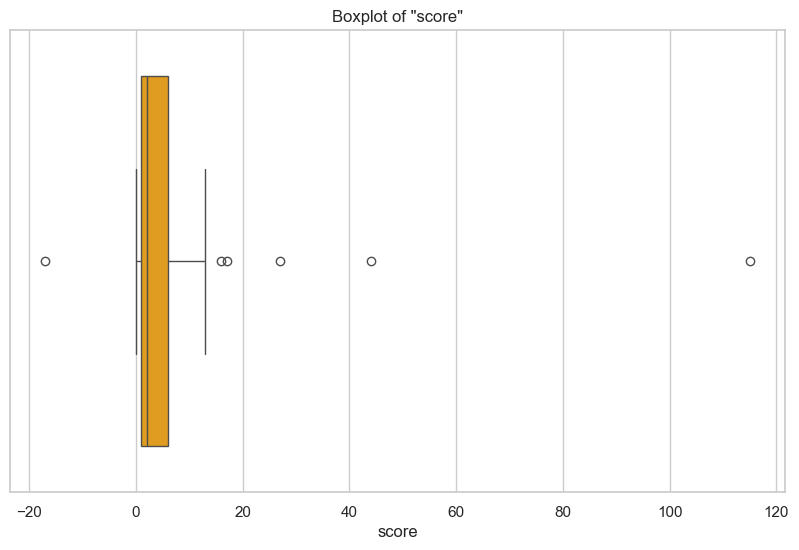

In [21]:
sns.boxplot(x=df_comments['score'], color='orange')
plt.title('Boxplot of "score"')
plt.xlabel('score')
plt.savefig('../reports/figures/eda/reddit-comments/boxplot_score.png')
plt.show()

<br>

### Data Quality Control
``Objective:`` Clean up errors, empty values, malformed text, etc.

In [22]:
# Remove duplicates
df_comments.drop_duplicates(subset='body', inplace=True)

# Remove null values
df_comments.dropna(subset=['body'], inplace=True)

# Remove empty or very short comments
df_comments = df_comments[df_comments['body'].str.len() > 10]


print(f"\nDataset shape after cleaning: {df_comments.shape}.\n")
# Display the first few rows of the cleaned dataset
print("First few rows of the cleaned dataset:")
print(df_comments.head())


Dataset shape after cleaning: (43, 7).

First few rows of the cleaned dataset:
  comment_id                                               body  \
0    m8yc3ia  No es que son 5000, son 5000 por cada persona ...   
1    m8yjtrr  Lo hacen de toda la vida. Antes eran los "SMS ...   
2    m8zffac  por eso mismo me fui de personal en su momento...   
3    m901q6d  Telefono pre pago, desde el Nokia 1100 hasta d...   
4    m90pvr2  36 LUCAS POR 6GB!!!! KJJJ \r\nLiteralmente por...   

                 author   created_utc  score   parent_id  is_submitter  
0  International_Luck60  1.737743e+09    115  t3_1i924b2         False  
1         Happy_Scrotum  1.737745e+09     44  t3_1i924b2         False  
2              usergghs  1.737754e+09     16  t3_1i924b2         False  
3            Belkan2087  1.737761e+09      8  t3_1i924b2         False  
4               Storpa2  1.737769e+09      8  t3_1i924b2         False  


After applying a basic minimum cleaning, we proceed to preprocess the text or rather, to treat the ``'body'`` column.

<br>

### Basic text preprocessing
``Objective``: Normalize the text so that it is analyzable and comparable.

In [23]:
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text): 
    text = text.lower() # Convert to lowercase 
    text = re.sub(r'http\S+|www\S+', '', text) # Delete URLs 
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove signs and numbers 
    text = ' '.join([lemmatizer.lemmatize(word) 
                     for word in text.split() if word not in stop_words]) 
    return text

df_comments['clean_text'] = df_comments['body'].apply(clean_text)

print('\nThe data has been successfully normalized.\n')



The data has been successfully normalized.



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Pc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<br>

### Visual Text Scan
``Objective``: See general patterns: frequency, length, keywords.

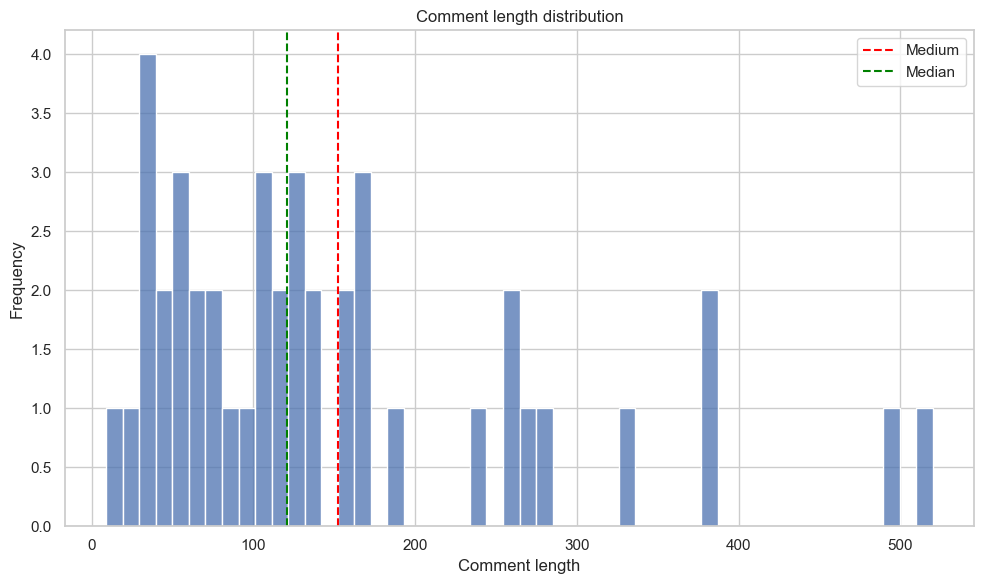

In [24]:
# Comment length
df_comments['text_length'] = df_comments['clean_text'].apply(len)
sns.histplot(df_comments['text_length'], bins=50)
plt.title('Comment length distribution')
plt.xlabel('Comment length')
plt.ylabel('Frequency')
plt.axvline(df_comments['text_length'].mean(), color='red', linestyle='--', label='Medium')
plt.axvline(df_comments['text_length'].median(), color='green', linestyle='--', label='Median')
plt.legend()
plt.tight_layout()
plt.savefig("../reports/figures/eda/reddit-comments/comment_length_distribution.png")
plt.show()

### Word Frequency Analysis
``Objective``: Find the most common terms.

***Word cloud***

Using the wordcloud library we are going to generate, pardon the redundancy, a word cloud.

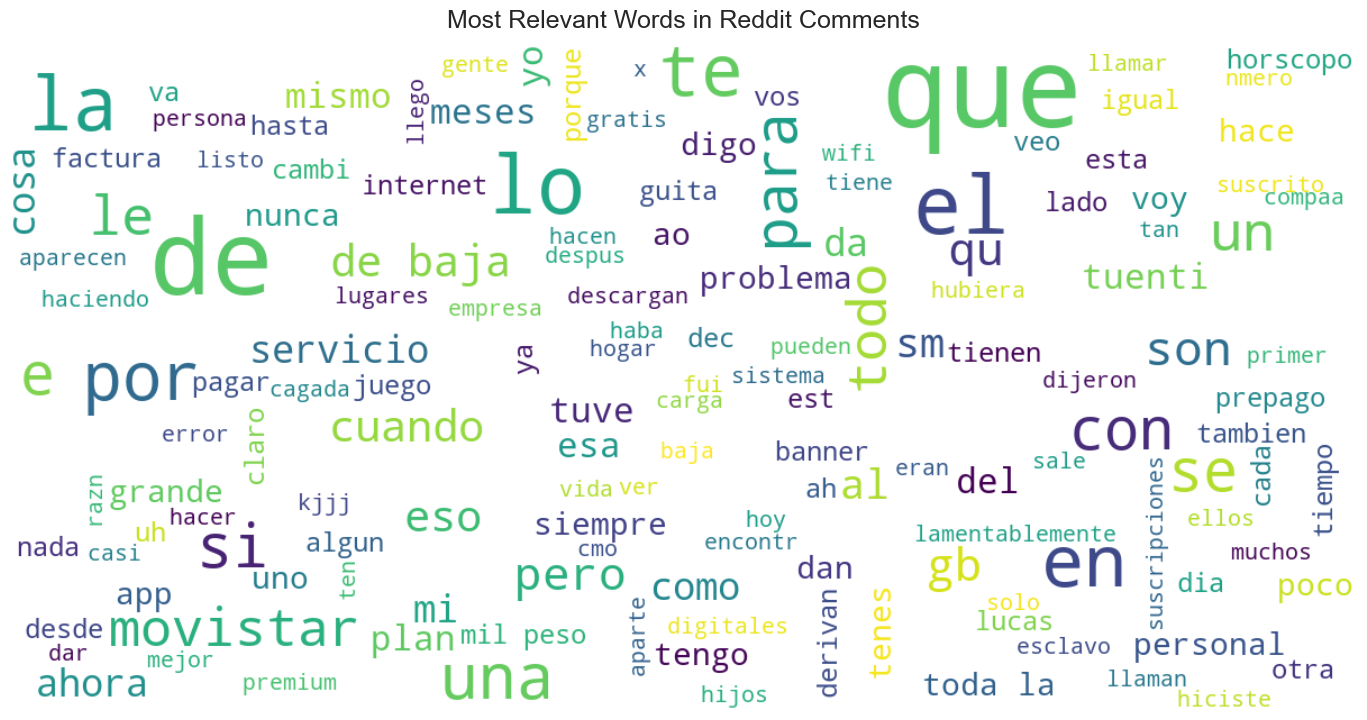

In [29]:
# Combine stopwords from WordCloud and NLTK
custom_stopwords = set(STOPWORDS).union(set(stopwords.words('english')))

# Concatenate all the text in the 'clean_text' column of the DataFrame
text = ' '.join(df_comments['clean_text'].dropna())

# Create the word cloud
wordcloud = WordCloud( 
width=1200, 
height=600, 
background_color='white', 
stopwords=custom_stopwords, 
colormap='viridis',
max_words=150, 
max_font_size=100, 
random_state=42
).generate(text)

# View
plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Relevant Words in Reddit Comments', fontsize=18)
plt.tight_layout(pad=0)
plt.savefig("../reports/figures/eda/reddit-comments/wordcloud_all.png", dpi=300)
plt.show()

We can sort to see the most frequent words in order using a bar chart.

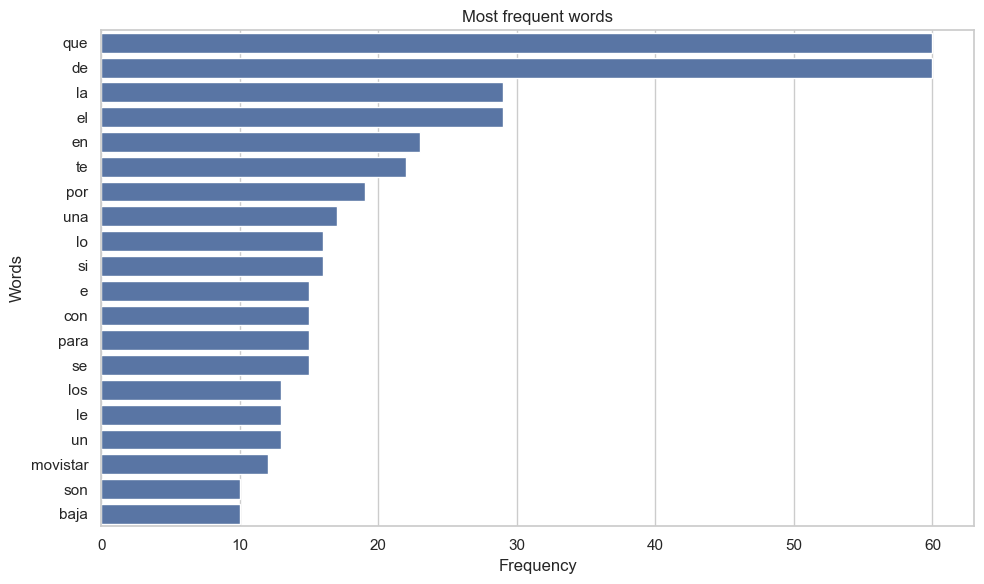

In [30]:
all_words = ' '.join(df_comments['clean_text']).split()
word_freq = Counter(all_words).most_common(20)

words, counts = zip(*word_freq)
sns.barplot(x=list(counts), y=list(words))
plt.title("Most frequent words")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.tight_layout()
plt.savefig("../reports/figures/eda/reddit-comments/most_frequent_words.png")
plt.show()

To improve this analysis a little, we modified it to filter by words with more than 2 letters.

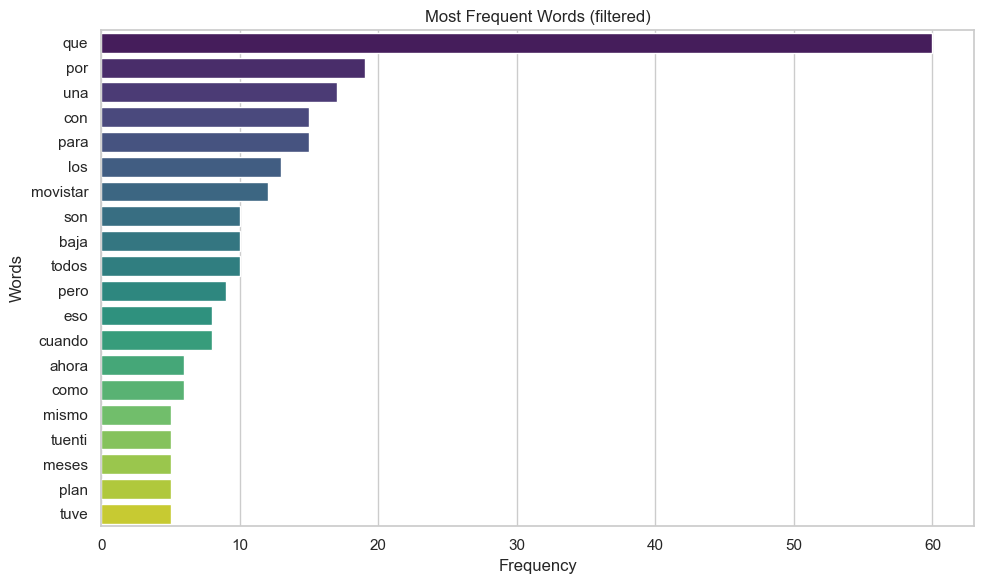

In [31]:
# Extract all words and filter out stopwords + very short words
all_words = [
    word for text in df_comments['clean_text']
    for word in text.split()
    if word not in stop_words and len(word) > 2 # len > 2 to avoid things like "i", "to"
]

# Count the most frequent words
word_freq = Counter(all_words).most_common(20)

# Unpack and plot
words, counts = zip(*word_freq)
sns.barplot(x=list(counts), y=list(words), palette="viridis")
plt.title("Most Frequent Words (filtered)")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.tight_layout()
plt.savefig("../reports/figures/eda/reddit-comments/most_frequent_words_filtered.png")
plt.show()

This reveals some more relevant words.

With this information, we are ready for the next stage, where we will preprocess and generate new columns to obtain a more robust dataset for modeling.

<br>

<hr>

## Author

<a href="https://www.linkedin.com/in/flavio-aguirre-12784a252/">**Flavio Aguirre**</a>
<br>
<a href="https://coursera.org/share/e27ae5af81b56f99a2aa85289b7cdd04">***Data Scientist***</a>